In [1]:
import pandas as pd
from fastai.vision.all import *
from fastai.metrics import error_rate
from os import walk
from os.path import relpath
from pathlib import Path
from torch import cuda

In [2]:
cuda.is_available()

True

## Load data

In [3]:
# Images Path
root_path = Path('/home/roldanx/code/artificial_intelligence/ownAI/fastai_faces')
path_to_data = Path('/home/roldanx/code/artificial_intelligence/ownAI/fastai_faces/faces/train')

filelist = [relpath(os.path.join(dp, f), path_to_data) for dp, dn, filenames in os.walk(path_to_data) 
            for f in filenames]

data_tuples = list(zip(filelist, [x.split("/")[0] for x in filelist]))
df = pd.DataFrame(data_tuples, columns=['Path', 'Label'])
df

,Path,Label
0,angry/Training_27071420.jpg,angry
1,angry/Training_92894213.jpg,angry
2,angry/Training_32830476.jpg,angry
3,angry/Training_36894301.jpg,angry
4,angry/Training_44277429.jpg,angry
...,...,...
28704,surprise/Training_3690136.jpg,surprise
28705,surprise/Training_92608034.jpg,surprise
28706,surprise/Training_69930631.jpg,surprise
28707,surprise/Training_77881805.jpg,surprise


## Prepare data

In [4]:
# DATA AUGMENTATION
#     # Optinal transformations
# extra_tfms = jitter(magnitude=0.005, p=0.2)
#     # Get transforms
# tfms = get_transforms(do_flip=False, max_rotate=20, flip_vert=False, max_zoom=1.05, max_lighting=0.1, xtra_tfms=extra_tfms)

In [5]:
# POR QUÉ VA MEJOR SIN NORMALIZAR QUE NORMALIZANDO???
# POR QUÉ VA MEJOR SIN NORMALIZAR QUE NORMALIZANDO???
# POR QUÉ VA MEJOR SIN NORMALIZAR QUE NORMALIZANDO???
dls = ImageDataLoaders.from_df(df, path_to_data, valid_pct=0.2, label_col=1, bs=64, item_tfms=Resize(32))
# dls = ImageDataLoaders.from_df(df, path_to_data, valid_pct=0.2, label_col=1, bs=64, val_bs=32, 
#                                size=128, batch_tfms=Normalize.from_stats(*imagenet_stats))

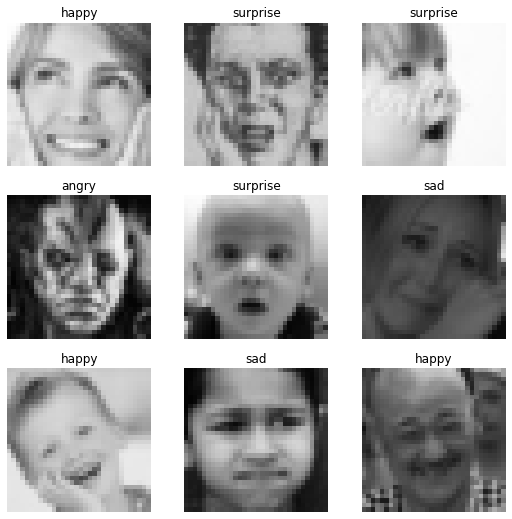

In [6]:
dls.show_batch()

## Import CNN model

In [7]:
# Choose model
arch_model = models.resnet50

In [8]:
# Build TL model based on arch
learning_model = cnn_learner(dls, arch_model, metrics=[accuracy, error_rate])

In [9]:
# learning_model.model

In [10]:
# Labels counter
from collections import Counter
labels_count = Counter(label for label in df['Label'])
labels_count

Counter({'angry': 3995,
         'happy': 7215,
         'disgust': 436,
         'sad': 4830,
         'fear': 4097,
         'neutral': 4965,
         'surprise': 3171})

In [11]:
# Get Class Weights --> This will allow us to compensate the classes with less data
total_count = sum(labels_count.values())
class_weights = {cls: total_count / count for cls, count in labels_count.items()}
class_weights

{'angry': 7.186232790988736,
 'happy': 3.979071379071379,
 'disgust': 65.84633027522936,
 'sad': 5.943892339544513,
 'fear': 7.007322431047108,
 'neutral': 5.782275931520645,
 'surprise': 9.053610848312836}

In [12]:
weights = [*class_weights.values()]
class_weights=torch.FloatTensor(weights).cuda()
learning_model.crit = nn.CrossEntropyLoss(weight=class_weights)

## Training stage 1

SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=7.585775847473997e-07)

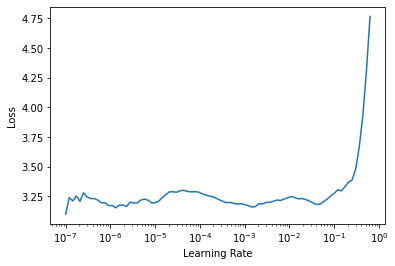

In [13]:
######################################## POR Q ME SALE ESTA MIERDA DE LR?????
# LR Finder helps to pick a good learning rate
learning_model.lr_find()

In [14]:
# Train
learning_model.fit_one_cycle(3, 1e-02)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.060900,1.960025,0.345933,0.654067,00:21
1,1.796113,1.723886,0.359345,0.640655,00:21
2,1.615773,1.659939,0.428671,0.571329,00:21


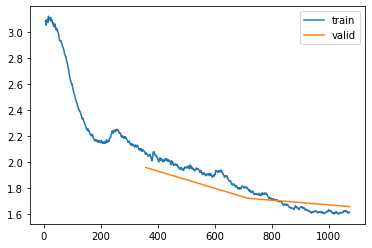

In [15]:
# Plot losses
learning_model.recorder.plot_loss()

In [16]:
# dump_tensors()

In [17]:
import gc
gc.collect()

13089

In [18]:
cuda.empty_cache()

In [19]:
# Save stage 1
# model_name = "resnet18_stage1"
# learning_model.save(root_path / model_name)

## Training stage 2

SuggestedLRs(lr_min=1.9054606673307718e-05, lr_steep=1.9054607491852948e-06)

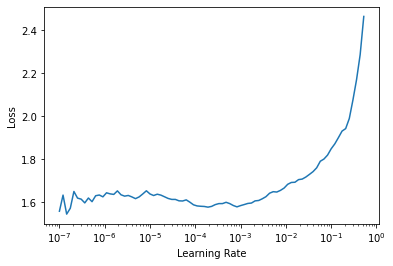

In [20]:
# Unfreeze
learning_model.unfreeze()

# Find LR
learning_model.lr_find()

In [21]:
# Train
learning_model.fit_one_cycle(2, (slice(1e-6, 1e-4)))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.591546,1.671925,0.440516,0.559484,00:30
1,1.502923,1.500874,0.446264,0.553736,00:29


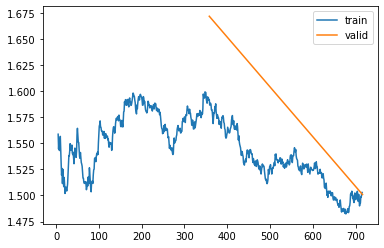

In [22]:
# Plot losses
learning_model.recorder.plot_loss()

In [23]:
# Save stage 1
# model_name = "BEST_resnet50_stage2_noNORM"
# learning_model.save(root_path / model_name)

## Stage 3

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.2022644114040304e-05)

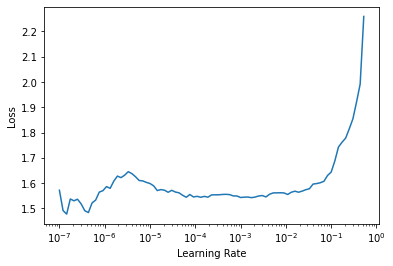

In [24]:
# Re-load data
dls = ImageDataLoaders.from_df(df, path_to_data, valid_pct=0.2, label_col=1, bs=64, item_tfms=Resize(128))
learning_model.data = dls

# Freeze
learning_model.freeze()

# Find LR
learning_model.lr_find()

In [27]:
# Re-train
learning_model.fit_one_cycle(4, slice(1e-03, 1e-05))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.311096,1.590975,0.452534,0.547466,00:27
1,1.341880,1.476664,0.454799,0.545201,00:27
2,1.304771,1.564196,0.454799,0.545201,00:27
3,1.301412,1.713760,0.456192,0.543808,00:28


## Stage 4

SuggestedLRs(lr_min=2.7542287170945203e-07, lr_steep=2.2908675418875646e-06)

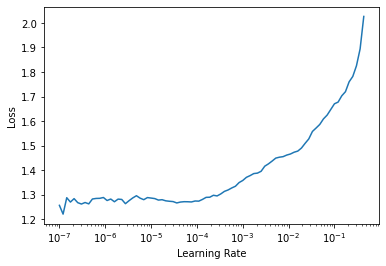

In [28]:
# Freeze
learning_model.unfreeze()

# Find LR
learning_model.lr_find()

In [29]:
learning_model.fit_one_cycle(2, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.291418,1.473328,0.466469,0.533531,00:29
1,1.215325,1.443051,0.470301,0.529699,00:29


In [ ]:
# Plot losses
learning_model.recorder.plot_loss()